# Likelihood
### open source data quality monitor

Colin Jemmott
2020

Have you ever found out an ETL job failed because a customer called?  You ever retrain a machine learning model in production just to find out the data changed out from under you?  Have a dashboard break because new data violated your assumptions?

### Approach

Everything is probability (or, rather [surprise](https://en.wikipedia.org/wiki/Entropy_(information_theory)#Introduction)!).  Works on a two dataframes for now - you have to get the data.

Batch job, you pass in training and test.

Taxonomy of problems for initial launch:
- New values in categorical - bootstrapping
- Missing values - bootstrapping (Nan is just another category)
- Outliers in counts (missing or spike) - prophet

To Do:

- Outliers in counts of groups - bootstrapping
- Outliers in values - kernel density?

Later:
- Outliers in correlation between categories - assocation rules / Bayesian network / just conditional probability
- Delayed data (I think we need a writtenAt timestamp)
- Multi-table: check joins
- PCA?  Other anomaly detection?
- Multitenant

### Tips

Some of the analysis assumes that the data is stationary (ergodic).  If that is a bad assumption it might make sense to trim history.  maxTrainingSizeMultiple controls that.

### To Do

- Change out data for something public (SDPD?)
- Write params to JSON
- preprocessor on bootsrtapping for columns with tons of entries.  Also numerical columns?
- Throw a warning or error if the testing sample is too small?

In [1]:
import pandas as pd
import math as mt
import dateutil
from datetime import datetime, timedelta
import requests as rd
import numpy as np
import scipy.stats
from sklearn import neighbors, decomposition

# Get data

Not part of the actual product, but here for ease of testing.

In [91]:
import os
import pandas as pd
from datetime import datetime, timedelta


N_days = 90
batchHours = 7*24 # this grabs the most recent chunk and looks for differences with the remainder


# parameters (will put into JSON config file later)
params = {"fName": "pd_calls_for_service_2020_datasd.csv", # local CSV file only right now
          "ts": "date_time", # Timestamp for when the event happened in the world
          "bootstrapResamples":1000, # should probably be 10k for better accuracy, but much worse speed
          "maxTrainingSizeMultiple":10, # if there is more than X times more training data, trim to most recent
          "maxCategories":100, # maximum number of categories in a column - if higher we skip
          "minCategoryCount":10, # don't report boostrap surprise if a category has lower count
         }

## Load data, split into training and test

In [92]:
df = pd.read_csv("pd_calls_for_service_2020_datasd.csv")
if(df.shape[0] <= 1000):
    print("Warning: small data set might produce inaccurate results")
df['ts'] = df[params['ts']]
print(df)
#.apply(dateutil.parser.parse, ignoretz=True) # could speed this up for ISO8601 - currently slow.
df['ts'] =  pd.to_datetime(df['ts'], format='%Y%m%d %H:%M:%S')
maxTs = max(df['ts'])
#df = df.assign(date_time = df.get("date_time").apply(datetime.strptime, args = ("%d/%m/%Y %H:%M:%S")))
batchTs = maxTs - timedelta(hours = batchHours)
testDf = df[df['ts'] > batchTs]
trainDf = df[df['ts'] < batchTs]

FileNotFoundError: [Errno 2] File b'pd_calls_for_service_2020_datasd.csv' does not exist: b'pd_calls_for_service_2020_datasd.csv'

In [ ]:
trainDf.keys()

In [ ]:
max(trainDf['ts'])

In [ ]:
# Helpers and Math
def pValue(data, threshold):
    p_larger = sum(np.array(data) >= threshold) / len(data)
    p_smaller = sum(np.array(data) <= threshold) / len(data)
    p = min(p_larger, p_smaller)

    # only use gaussian p-value when there is variation, but bootsrap p = 0
    stdev = np.std(data)
    if stdev == 0 or p != 0:
        p_gauss = p
    else:
        p_gauss = scipy.stats.norm(np.mean(result['bootstrap_counts']), stdev).cdf(result['count'])
        p_gauss = min(p_gauss,1-p_gauss)
    return p_gauss

def trimTraining(trainDf, params):

    # trim to most recent
    trainDf = trainDf.sort_values(params['ts'], ascending =False)
    trainDfTrimmed = trainDf[:params['maxTrainingSizeMultiple']*len(testDf)]
    
    return trainDfTrimmed

In [90]:
# get all of the string columns
columnNames = []
for columnName in testDf.keys():
    if (type (testDf[columnName].iloc[0])) == str:
        columnNames.append(columnName)
print(columnNames)
bootstrapDf = trimTraining(trainDf, params)
        
# set up dict, add counts
results = {}
for columnName in columnNames:
    # if it isn't a string column, reject it
    if type(testDf[columnName].iloc[0]) != str:
        continue
    categories = (bootstrapDf[columnName].append(testDf[columnName])).unique()
    if len(categories) > params['maxCategories']:
        continue
    
    results[columnName] = {}
    testCounts = testDf[columnName].value_counts(dropna = False)
    for i in np.arange(1,len(categories) -1):
        if(pd.isna(categories[i])):
            categories = np.delete(categories, i)  
    for category in categories:
        results[columnName][category] = {'bootstrap_counts':[],
                                        'count':testCounts.get(category,0)}
# resample, add boostrap counts
for ii in range(params['bootstrapResamples']):
    # Draw random sample from training
    sampleDf = bootstrapDf.sample(len(testDf), replace=True)
    for columnName in results.keys():
        # count by category
        trainCounts = sampleDf[columnName].value_counts(dropna = False)
        # put results in dict
        for category in results[columnName].keys():
            boostrapCount = trainCounts.get(category,0)
            results[columnName][category]['bootstrap_counts'].append(boostrapCount)
              
# convert to records, add p-values
bootstrap_results = []
for columnName in results.keys():
    for category in results[columnName].keys():
        result = results[columnName][category]
        
        estimatedCount = int(np.round(np.mean(result['bootstrap_counts'])))
        # don't report entries with very low predicted and actual counts
        if estimatedCount < params['minCategoryCount'] and result['count'] < params['minCategoryCount']:
            continue
        
        p = pValue(result['bootstrap_counts'],result['count'])
        categoryName = category
        if not category:
            categoryName = "NULL"
        
        bootstrap_results.append({"column":columnName,
                           "category":categoryName,
                           "count":result['count'],
                           "p": p,
                           "estimated_count":estimatedCount,
                           })
if(np.count_nonzero(p)>0):
    resultsDf = pd.DataFrame.from_records(bootstrap_results).sort_values('p')
    resultsDf['surprise'] = -np.log2(resultsDf['p'])

NameError: name 'testDf' is not defined

In [89]:
resultsDf.head(70)

NameError: name 'resultsDf' is not defined

# Timeseries forecast (prophet)

Installing prophet is a major pain, especially on Windows.  Details: https://facebook.github.io/prophet/docs/installation.html

Following the lead from Seismic interns: https://medium.com/seismic-data-science/anomaly-detection-using-prophet-a5dcea2c5473

Decided to go hourly, but could change to day with a few tweaks.

In [ ]:
from fbprophet import Prophet

In [ ]:
def truncateTs(ts):
    return ts.replace(minute=0, second=0,  microsecond=0)

In [ ]:
truncatedData = trainDf['ts'].apply(truncateTs)
groupedCounts = truncatedData.value_counts()

prophetDf = pd.DataFrame({'ds':groupedCounts.index,'y':np.log10(groupedCounts.values)})
prophetDf

In [ ]:
# find number of hours to preduct: ceil of hours in testDf
timeDelta = max(testDf['ts']) -min(testDf['ts'])
hours = int(timeDelta.days*24 + timeDelta.seconds/(60*60))+1
 
# Train model
m = Prophet(#daily_seasonality = True, 
            #yearly_seasonality = False, 
            #weekly_seasonality = True, 
            #growth='linear',
            interval_width=0.68 # one sigma
           )
m.add_country_holidays(country_name='US')

m.fit(prophetDf)

future = m.make_future_dataframe(periods = hours, freq = 'H')
fcst = m.predict(future)

In [ ]:
# group the test data
truncatedData = testDf['ts'].apply(truncateTs)
groupedCounts = truncatedData.value_counts()

prophetTestDf = pd.DataFrame({'ds':groupedCounts.index,
                              'y':np.log10(groupedCounts.values),
                              'y_linear':groupedCounts.values})

# find p-value
prophet_results = []

for ii in range(len(prophetTestDf)):
    ts = prophetTestDf['ds'][ii]
    fcstExample = fcst[fcst['ds'] == ts]
    mean = fcstExample['yhat'].iloc[0]
    stdev = (fcstExample['yhat_upper'].iloc[0] - fcstExample['yhat_lower'].iloc[0])/2
    p = scipy.stats.norm(mean, stdev).cdf(prophetTestDf['y'][ii])
    p = min(p,1-p)

    prophet_results.append({"column":"Forecast",
                       "category":str(ts),
                       "count":prophetTestDf['y_linear'][ii],
                       "p": p,
                       "estimated_count":int(np.round(np.power(10,mean))),
                       })
    
prophetResultsDf = pd.DataFrame.from_records(prophet_results).sort_values('p')
prophetResultsDf['surprise'] = -np.log2(prophetResultsDf['p'])
prophetResultsDf

In [ ]:
# plotting for debug only
fig = m.plot(fcst)
fig = m.plot_components(fcst)

# Kernel Density Implementation Below

In [2]:
#obtaining user input
#https://www.nbastuffer.com/2019-2020-nba-team-stats/
def inp(default = 1, default2 = "https://www.nbastuffer.com/2019-2020-nba-team-stats/"):
    if(default2 != "https://www.nbastuffer.com/2019-2020-nba-team-stats/"):
        nam = input()
    else:
        nam = default2
    frame = pd.read_html(nam)
    first_table = frame[default]
    return first_table
first_table = inp(1,"input")

https://www.nbastuffer.com/2019-2020-nba-team-stats/


In [3]:
first_table

,RANK,TEAM,CONF,DIVISION,GP,PTS/GMPoints Per GameAverage points per game,aPTS/GMPoints Allowed Per GameAverage points allowed per game,PTS DIFFPoints Differential{(Total Points Scored) - (Total Points Allowed)}/ (Games Played),PACEPaceEstimate of Possessions Per 48 Minutes,OEFFOffensive EfficiencyPoints scored per 100 possessions.,...,SARSchedule Adjusted RatingAn evaluation of teams based on efficiency differential and strength of schedule,"CONSConsistency RatingConsistency based on game-by-game efficiency differential variation. The higher the team has a consistency rating, the more unpredictable it is.",A4FAdjusted Four FactorsCalculated by applying weights to the differentials of offensive and defensive four factors. A4F explains the specified proportion of variability in wins.,"WWinsThe most important goal in sports, unless your team is not tanking",LLossesTotal count of games lost,WIN%,eWIN%Correlated Gaussian Expected Winning PercentageIndicates the ideal winning percentage based on offensive and defensive performance.,pWIN%Projected Winning PercentageEach point differential translates to 2.7 wins over the course of the season.,ACHAchievement Level In Terms of Wins. The metric is based on differential between actual and expected winning percentage. Positive figures indicate overachievement while negative figures indicate the team should have won more games.,STRKLast 5 Games StreakWinning or losing streak for the last 5 games.
0,NaN,Atlanta,East,Southeast,5,115.0,127.4,-12.4,100.0,108.2,...,-15.89,16.2,-0.047,1,4,0.2,0.230,0.092,-0.030,L 1
1,NaN,Boston,East,Atlantic,5,108.8,110.0,-1.2,97.7,109.1,...,-1.50,5.9,-0.026,2,3,0.4,0.433,0.460,-0.033,W 1
2,NaN,Brooklyn,East,Atlantic,5,112.2,113.4,-1.2,100.3,108.9,...,-0.61,22.7,-0.006,4,1,0.8,0.465,0.460,0.335,W 3
3,NaN,Charlotte,East,Southeast,5,114.0,111.6,2.4,90.1,121.3,...,3.67,7.7,-0.004,2,3,0.4,0.647,0.579,-0.247,W 1
4,NaN,Chicago,East,Central,5,106.8,108.6,-1.8,99.6,107.3,...,-3.00,5.3,-0.042,2,3,0.4,0.366,0.441,0.034,W 1
5,NaN,Cleveland,East,Central,5,111.6,115.4,-3.8,96.5,113.0,...,-4.01,6.8,-0.015,2,3,0.4,0.273,0.375,0.127,L 1
6,NaN,Dallas,West,Southwest,5,115.8,109.4,6.4,100.5,112.9,...,5.38,14.3,-0.005,3,2,0.6,0.673,0.711,-0.073,W 1
7,NaN,Denver,West,Northwest,5,104.4,108.0,-3.6,96.4,108.6,...,-5.45,12.9,-0.017,2,3,0.4,0.381,0.381,0.019,L 1
8,NaN,Detroit,East,Central,5,100.4,110.2,-9.8,94.3,106.5,...,-9.17,5.5,-0.033,0,5,0.0,0.028,0.177,-0.028,L 5
9,NaN,Golden State,West,Pacific,5,112.8,118.0,-5.2,97.8,115.8,...,-4.65,16.2,-0.006,2,3,0.4,0.379,0.329,0.021,L 1


### Stat Computations for Formulas Found Below

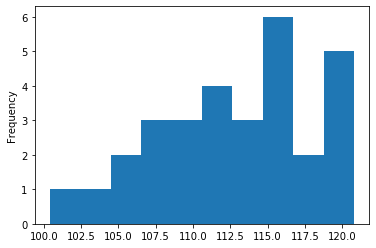

In [4]:
def getParam(default = "PTS/GMPoints Per GameAverage points per game"):
    #Stuff beyond here focuses on kernel density, it is a work in progress
    if(default != "PTS/GMPoints Per GameAverage points per game"):
        print("Enter the column name you'd like to get a kernel density estimation for:")
        #Prompting user for input and calculating basic statistics, bandwidth temporarily set to .05
        #For testing purposes
        inp = input()
    else:
        inp = default
    stat = first_table.get(inp)
    return stat
stat = getParam()
#Index for purpose of making table nicer
def getIndex(indx = "TEAM"):
    if(indx!="TEAM"):
        print("Please enter the name of the column you'd like to serve as your index:")
        indx = first_table.get(input())
    else:
        indx = first_table.get(indx)
    return indx
indx = getIndex()

#Plotting Data initially
stat.plot(kind  = "hist")
avg = stat.mean()
density = np.array([])
n = first_table.shape[0]
dev = np.std(stat)

kernelEstimations = pd.DataFrame()


The Kernel Estimation for a Gaussian, Cosine, Triangular, and Parabolic Kernel are found below, metric used for surprise computation will be based on their average. Idea is: if between them we can found a standard density, we can find values that are more likely to be outliers. Other idea: find outliers for every one and check for commonalities.

### Scikit learn citation because their software is utilized
@article{scikit-learn,
 title={Scikit-learn: Machine Learning in {P}ython},
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research},
 volume={12},
 pages={2825--2830},
 year={2011}
}

In [5]:
# Using cosine kernel function to get estimate for log density
def cosKernel(stat):
    stat = stat.to_numpy().reshape(-1,1) 
    l = neighbors.KernelDensity(kernel = 'cosine').fit(stat)
    density = l.score_samples(stat)
    return density

In [6]:
# Using gaussian kernel function to get estimate for log density
def gaussKernel(stat):
    stat = stat.to_numpy().reshape(-1,1) 
    l = neighbors.KernelDensity(kernel = 'gaussian').fit(stat)
    density = l.score_samples(stat)
    return density

In [7]:
# Using linear kernel function to get estimate for log density
def expKernel(stat):
    stat = stat.to_numpy().reshape(-1,1) 
    l = neighbors.KernelDensity(kernel = 'exponential').fit(stat)
    triDensity = l.score_samples(stat)
    return triDensity

In [8]:
# converted to Proportion for u < 1 supported functions
def toProp(number):
    return number/max(number)

In [9]:
# Using epanechnikov kernel function to get estimate for log density
def parabolicKernel(stat):
    stat = stat.to_numpy().reshape(-1,1) 
    l = neighbors.KernelDensity(kernel = 'epanechnikov').fit(stat)
    epDensity = l.score_samples(stat)
    return epDensity

## Kernel Values Data

In [10]:
# Assigning initial kernal estimations
def kernelEstimator(indx, stat):
    kernelEstimate = pd.DataFrame()
    print("Kernel Estimations as raw values found below:")
    kernelEstimate = kernelEstimate.assign(Data_Index = indx, Data_Point = stat,Gaussian = gaussKernel(stat),
                                               Epanechnikov = parabolicKernel(stat), Exponential = expKernel(stat),
                                               Cosine = cosKernel(stat))
    # temporary sort for some visualization of surprise
    kernelEstimate = kernelEstimate.sort_values(by = "Gaussian", ascending = False)
    return kernelEstimate
kernelEstimation = kernelEstimator(indx, stat)
kernelEstimation

Kernel Estimations as raw values found below:


,Data_Index,Data_Point,Gaussian,Epanechnikov,Exponential,Cosine
27,Toronto,116.2,-2.577962,-2.333044,-2.575014,-2.324728
6,Dallas,115.8,-2.591776,-2.617296,-2.636409,-2.636240
26,San Antonio,116.6,-2.615355,-2.292635,-2.533969,-2.274873
25,Sacramento,116.6,-2.615355,-2.292635,-2.533969,-2.274873
0,Atlanta,115.0,-2.689539,-2.847312,-2.674663,-2.827365
23,Phoenix,117.0,-2.714933,-2.577022,-2.688015,-2.568766
14,Memphis,114.8,-2.716265,-2.847312,-2.684348,-2.827365
22,Philadelphia,120.0,-2.759223,-2.273026,-2.691940,-2.251443
12,LA Clippers,119.8,-2.767984,-2.364460,-2.695215,-2.331425
18,New Orleans,120.2,-2.778501,-2.282782,-2.749205,-2.272687


In [11]:
# Calculating their average
def surprise_estimator(kernelEstimation):
    numDevMax = (kernelEstimation.get("Data_Point").max() - kernelEstimation.get("Data_Point").mean())/kernelEstimation.get("Data_Point").std()
    numDevMin = (kernelEstimation.get("Data_Point").min() - kernelEstimation.get("Data_Point").mean())/kernelEstimation.get("Data_Point").std()
    numDev = max(numDevMax, numDevMin)
    if(numDev > 3.2):
        metric = abs(kernelEstimation.get("Exponential"))
    elif((numDev <=3.2) & (numDev >= 2)):
        metric = abs(kernelEstimation.get("Gaussian"))
    else:
        metric = (abs(kernelEstimation.get("Exponential")+kernelEstimation.get("Epanechnikov")))/2          
    # Surprise Metric
    kernelEstimation  = kernelEstimation.assign(surprise = metric)
    kernelEstimation = kernelEstimation.sort_values(by = "surprise", ascending = False)
    return kernelEstimation
kernelEstimation = surprise_estimator(kernelEstimation)
kernelEstimation

,Data_Index,Data_Point,Gaussian,Epanechnikov,Exponential,Cosine,surprise
8,Detroit,100.4,-4.319627,-3.688879,-4.048488,-3.642762,3.868684
17,Minnesota,118.0,-3.101794,-3.688879,-3.012922,-3.642762,3.350901
4,Chicago,106.8,-3.276090,-3.194183,-3.173352,-3.180422,3.183767
24,Portland,120.8,-3.018420,-2.995732,-3.062748,-3.002592,3.029240
19,New York,110.8,-2.904050,-3.146555,-2.902212,-3.161550,3.024383
9,Golden State,112.8,-2.833880,-3.194183,-2.827621,-3.180422,3.010902
28,Utah,108.0,-3.040088,-2.995732,-3.017717,-3.002592,3.006725
1,Boston,108.8,-3.003869,-2.995732,-2.979759,-3.002592,2.987745
10,Houston,110.0,-2.982687,-2.995732,-2.941105,-3.002592,2.968419
20,Oklahoma City,105.0,-3.213439,-2.780621,-3.145212,-2.768626,2.962916


The Exponential Density should apply to a more fat-tailed distribution, and makes less assumption of outliers, others assume a less spread out (parabolic and cosine) or normal (gaussian) distribution. To truly quantify an outlier, exponential density should be used.

# Visualization Below

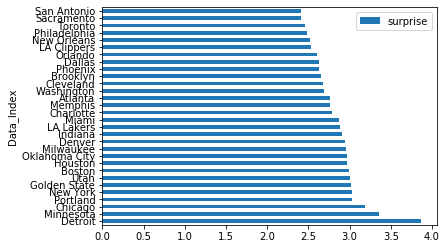

In [12]:
kernelEstimation.plot(kind = "barh", x="Data_Index", y = "surprise")

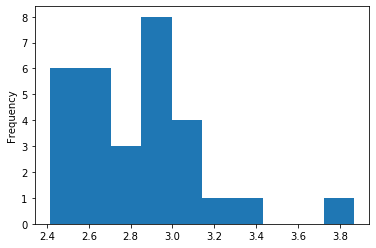

In [13]:
kernelEstimation.get("surprise").plot(kind = "hist")

# PCA and Singular Value Decomp for Cross Column Correlation Lie Ahead

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import smtplib

In [46]:
def loader(first_table):
    # Giving user option to change dataset
    print("Would you like to change the data set you are working with?")
    if(input().upper() == "YES"):
        print("Enter the URL below:")
        nam = input()
        frame = pd.read_html(nam)
        table = frame[0]
        return table
    else:
        return first_table
first_table = loader(first_table)
print("\ndataset below:")
first_table

Would you like to change the data set you are working with?
yes
Enter the URL below:
https://www.nbastuffer.com/2019-2020-nba-team-stats/

dataset below:


,RANK,TEAM,CONF,DIVISION,GP,PTS/GMPoints Per GameAverage points per game,aPTS/GMPoints Allowed Per GameAverage points allowed per game,PTS DIFFPoints Differential{(Total Points Scored) - (Total Points Allowed)}/ (Games Played),PACEPaceEstimate of Possessions Per 48 Minutes,OEFFOffensive EfficiencyPoints scored per 100 possessions.,...,SARSchedule Adjusted RatingAn evaluation of teams based on efficiency differential and strength of schedule,"CONSConsistency RatingConsistency based on game-by-game efficiency differential variation. The higher the team has a consistency rating, the more unpredictable it is.",A4FAdjusted Four FactorsCalculated by applying weights to the differentials of offensive and defensive four factors. A4F explains the specified proportion of variability in wins.,"WWinsThe most important goal in sports, unless your team is not tanking",LLossesTotal count of games lost,WIN%,eWIN%Correlated Gaussian Expected Winning PercentageIndicates the ideal winning percentage based on offensive and defensive performance.,pWIN%Projected Winning PercentageEach point differential translates to 2.7 wins over the course of the season.,ACHAchievement Level In Terms of Wins. The metric is based on differential between actual and expected winning percentage. Positive figures indicate overachievement while negative figures indicate the team should have won more games.,STRKCurrent StreakWinning or losing streak for the season.
0,NaN,Atlanta,East,Southeast,67,111.8,119.7,-7.9,103.0,107.2,...,-6.12,15.2,-0.037,20,47,0.299,0.309,0.240,-0.010,L 1
1,NaN,Boston,East,Atlantic,64,113.0,106.8,6.2,99.2,112.9,...,5.28,11.8,0.013,43,21,0.672,0.697,0.704,-0.025,W 1
2,NaN,Brooklyn,East,Atlantic,64,110.8,111.4,-0.6,101.1,108.1,...,-1.12,13.8,0.048,30,34,0.469,0.483,0.480,-0.014,W 3
3,NaN,Charlotte,East,Southeast,65,102.9,109.6,-6.7,95.8,106.4,...,-6.09,13.2,-0.064,23,42,0.354,0.300,0.279,0.054,W 1
4,NaN,Chicago,East,Central,65,106.8,109.9,-3.1,99.7,106.7,...,-3.58,12.2,-0.082,22,43,0.338,0.399,0.398,-0.061,W 1
5,NaN,Cleveland,East,Central,65,106.9,114.8,-7.9,98.7,107.5,...,-7.67,14.4,-0.014,19,46,0.292,0.292,0.240,0.000,L 1
6,NaN,Dallas,West,Southwest,67,116.4,110.3,6.1,99.1,116.7,...,5.82,14.3,0.048,40,27,0.597,0.665,0.701,-0.068,W 1
7,NaN,Denver,West,Northwest,65,110.4,107.4,3.0,97.2,112.5,...,2.70,12.4,0.005,43,22,0.662,0.596,0.599,0.066,L 1
8,NaN,Detroit,East,Central,66,107.2,110.8,-3.6,97.6,109.0,...,-4.17,14.4,-0.011,20,46,0.303,0.398,0.381,-0.095,L 5
9,NaN,Golden State,West,Pacific,65,106.3,115.0,-8.7,100.3,105.2,...,-7.78,14.3,-0.097,15,50,0.231,0.274,0.214,-0.043,L 1


In [47]:
def pcaPrep(first_table):
# Finding all numerical components of the table so that pca can function
    tabl = first_table.select_dtypes(include = [np.number])
    tabl = tabl.dropna(1)
    return tabl

tabl = pcaPrep(first_table)
scaled_data = StandardScaler().fit_transform(tabl)
# Creating a PCA object 
pca = PCA(n_components = (tabl.shape[1]))
tabl

,GP,PTS/GMPoints Per GameAverage points per game,aPTS/GMPoints Allowed Per GameAverage points allowed per game,PTS DIFFPoints Differential{(Total Points Scored) - (Total Points Allowed)}/ (Games Played),PACEPaceEstimate of Possessions Per 48 Minutes,OEFFOffensive EfficiencyPoints scored per 100 possessions.,DEFFDefensive EfficiencyPoints allowed per 100 possessions.,EDIFFEfficiency Differential{(Total Offensive Efficiency) - (Total Defensive Efficiency)}/ (Games Played),"SOSStrength of the ScheduleOpponent efficiency differential average for all games played so far (venue of the games also taken into account) is used as an indicator of strength of the schedule. The higher the SoS rating, the tougher the schedule; where zero is average.","rSOSRemaining Strength of the ScheduleOpponent efficiency differential average for the remaining games (venue of the games also taken into account) is used as an indicator of strength of the schedule. The higher the rSOS rating, the tougher the remaining schedule; where zero is average.",SARSchedule Adjusted RatingAn evaluation of teams based on efficiency differential and strength of schedule,"CONSConsistency RatingConsistency based on game-by-game efficiency differential variation. The higher the team has a consistency rating, the more unpredictable it is.",A4FAdjusted Four FactorsCalculated by applying weights to the differentials of offensive and defensive four factors. A4F explains the specified proportion of variability in wins.,"WWinsThe most important goal in sports, unless your team is not tanking",LLossesTotal count of games lost,WIN%,eWIN%Correlated Gaussian Expected Winning PercentageIndicates the ideal winning percentage based on offensive and defensive performance.,pWIN%Projected Winning PercentageEach point differential translates to 2.7 wins over the course of the season.,ACHAchievement Level In Terms of Wins. The metric is based on differential between actual and expected winning percentage. Positive figures indicate overachievement while negative figures indicate the team should have won more games.
0,67,111.8,119.7,-7.9,103.0,107.2,114.8,-7.6,1.48,-1.29,-6.12,15.2,-0.037,20,47,0.299,0.309,0.240,-0.010
1,64,113.0,106.8,6.2,99.2,112.9,106.8,6.1,-0.82,0.23,5.28,11.8,0.013,43,21,0.672,0.697,0.704,-0.025
2,64,110.8,111.4,-0.6,101.1,108.1,108.7,-0.6,-0.52,0.32,-1.12,13.8,0.048,30,34,0.469,0.483,0.480,-0.014
3,65,102.9,109.6,-6.7,95.8,106.4,113.3,-6.9,0.81,-1.46,-6.09,13.2,-0.064,23,42,0.354,0.300,0.279,0.054
4,65,106.8,109.9,-3.1,99.7,106.7,109.8,-3.1,-0.48,2.17,-3.58,12.2,-0.082,22,43,0.338,0.399,0.398,-0.061
5,65,106.9,114.8,-7.9,98.7,107.5,115.4,-7.9,0.23,0.18,-7.67,14.4,-0.014,19,46,0.292,0.292,0.240,0.000
6,67,116.4,110.3,6.1,99.1,116.7,110.6,6.1,-0.28,1.10,5.82,14.3,0.048,40,27,0.597,0.665,0.701,-0.068
7,65,110.4,107.4,3.0,97.2,112.5,109.5,3.0,-0.30,1.64,2.70,12.4,0.005,43,22,0.662,0.596,0.599,0.066
8,66,107.2,110.8,-3.6,97.6,109.0,112.7,-3.7,-0.47,1.47,-4.17,14.4,-0.011,20,46,0.303,0.398,0.381,-0.095
9,65,106.3,115.0,-8.7,100.3,105.2,113.8,-8.6,0.82,0.57,-7.78,14.3,-0.097,15,50,0.231,0.274,0.214,-0.043


In [48]:
def obtainPCAVals(componentNum):
    pca = PCA(n_components = componentNum)
    pcaData = pca.fit_transform(scaled_data)
    return pcaData

(30, 19)


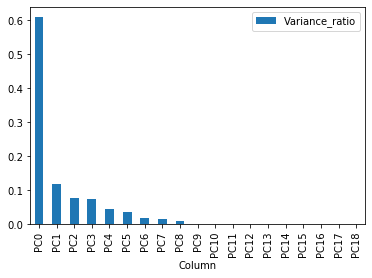

In [49]:
# Fitting data and creating plot showing variance of each PC
pcaData = pca.fit_transform(scaled_data)
print(pcaData.shape)
infoFrame = pd.DataFrame().assign(Column = ["PC" + str(i) for i in range(tabl.shape[1])], Variance_ratio = pca.explained_variance_ratio_ )
#Principal component variation visualization
infoFrame.plot(kind  = "bar", x = "Column", y = "Variance_ratio")

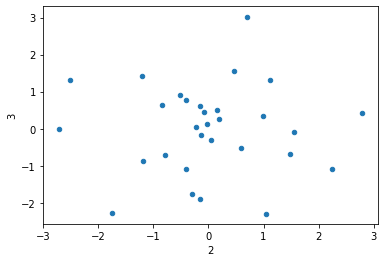

In [50]:
# Deciding how many columns need to be used: utilizing threashold of 95% of the explained variance
def elementDecider(infoFrame):
    numSum = 0
    counter = 0
    for i in infoFrame.get("Variance_ratio"):
        if(numSum < .95):
            numSum += i
            counter+=1
    return counter

#Reducing dimensionality of data into pc's, only storing what is neccessary
def reducedData(infoFrame, indx):
    numCols = elementDecider(infoFrame)
    pcaData = obtainPCAVals(numCols)
    pcaFrame = pd.DataFrame(pcaData)
    pcaFrame = pcaFrame.set_index(indx)
    return pcaFrame

#Visualization tool for seeing grouping of elements by pc
def displayReducedData(pcaVals, xNum = 0, yNum = 1):
    # Ensuring that the elements given do not overacess table 
    if(xNum < pcaVals.shape[1]) & (yNum < pcaVals.shape[1]):
        pcaVals.plot(kind = "scatter", x = 2, y = 3)
    else:
        print("You have overaccessed the number of elements, keep in mind there are only " + str(pcaVals.shape[1]) + " elements")
    
pcaVals = reducedData(infoFrame, indx)
displayReducedData(pcaVals)

In [51]:
# weirdRows takes the given table of pca values, and since the data is consistently centered at 0 (data has been standardized)
# it takes the total distance from the mean of 0 (essentially the sum of all values), if the data is systematically strange in some way
# the columns vary weirdly because one factor has caused systematic error then the row is given a "weird score"
def sumRows(pcaVals):
    sumArray = np.zeros(pcaVals.shape[0])
    for i in np.arange(pcaVals.shape[1]):
        values = pcaVals.get(i).array
        sumArray += values
    sumArray /= pcaVals.shape[1]
    #After obtaining sum, the average deviation from the expected value is averaged out, not taking in absolute value
    # to check for systematic error
    return sumArray
def pcaRowOutliers(pcaVals):
    totalVar = sumRows(pcaVals)
    is_it_weird = abs(totalVar) > 1.5
    newVals = pcaVals.assign(Outlier = is_it_weird )
    return newVals
new_pca = pcaRowOutliers(pcaVals)
new_pca

,0,1,2,3,4,5,Outlier
TEAM,,,,,,,
Atlanta,-5.159277,-1.563154,0.701319,3.026126,0.144387,-0.242164,False
Boston,3.889414,0.466592,-0.300828,-1.762485,0.947157,-0.543778,False
Brooklyn,-0.076034,-0.145179,-0.127675,-0.181345,-1.012995,-1.047585,False
Charlotte,-4.100396,3.463412,0.984451,0.346577,-0.156773,0.472463,False
Chicago,-2.775130,0.588968,-1.749744,-2.266596,-0.217988,-1.224264,False
Cleveland,-4.709832,0.567972,-0.147380,0.611318,-0.645669,0.587851,False
Dallas,2.898969,-1.519206,-2.509974,1.325053,2.629016,0.585949,False
Denver,2.435516,1.678675,-0.795786,-0.718072,-0.032050,1.610457,False
Detroit,-3.172593,0.273204,-2.718572,-0.005165,0.879378,-0.629288,False


### Attaching Program to Data Set Below

In [21]:
def main():
    table = inp()
    stat = getParam()
    indx = getIndex()
    kernelEstimation = kernelEstimator(indx, stat)
    kernelEstimation = surprise_estimator(kernelEstimation)
    ret = kernelEstimation[kernelEstimation.get("surprise") > 3]
    ret.to_csv('Likelihood')
main()

Kernel Estimations as raw values found below:


In [22]:
import schedule
import time

In [23]:
schedule.every().friday.do(main)

Every 1 week do main() (last run: [never], next run: 2020-06-26 21:04:54)

# Tackling the Categorical Question Below

The following are several categorical questions that could be tackled with this program, ultimately, this will be used in the report which assesses flaws in the data. I perceive the functionality to work something like a data spellcheck. 

Above, the question of is there a problem with the data and where is it will have already been answered by the time this section is utilized. This will attempt to answer why.

Some questions to be answered
1)Did the user make a simple typo? 
2)Does the data fit previous specifications? Has the metadata changed?
3)Are previously unseen values now appearing?

In [24]:
import Levenshtein as leven

1

# The Anomaly Report

This report will give the user a detailed picture of: is something wrong with their data, where is it, and hopefully why that is